# Weighted metric

In [3]:
from typing import Iterable, List

import numpy as np
import pandas as pd


def weighted_metric(mal_acc: List[float], benign_acc: float) -> float:
    """
    benign_acc: accuracy of benign class
    mal_acc: list of `s` accuracies
    0.5 * benign_acc + 0.5 * (1/(1+2+...+s)) * (s*mal_acc_1 + (s-1)*mal_acc_2 + ... + 1*mal_acc_s)
    """
    s = len(mal_acc)
    weights = list(range(s, 0, -1))

    mal_weighted_avg = np.average(mal_acc, weights=weights)

    weighted_avg = np.average([benign_acc, mal_weighted_avg], weights=[0.5, 0.5])

    return weighted_avg

def unweighted_metric(mal_acc: List[float], benign_acc: float) -> float:
    mal_avg = np.average(mal_acc)
    unweighted_avg = np.average([benign_acc, mal_avg])

    return unweighted_avg

def calc_metrics(df):
    benign_acc_centroid = df[df['lsb']==0]['test_acc_centroid'].iloc[0]
    benign_acc_nn = df[df['lsb']==0]['test_acc_nn'].iloc[0]

    df_mal = df[~(df['lsb'] == 0)].sort_values(by='lsb', ascending=True)

    mal_acc_centroid = df_mal['test_acc_centroid'].tolist()
    mal_acc_nn = df_mal['test_acc_nn'].tolist()

    unweighted_metric_centroid = unweighted_metric(mal_acc_centroid, benign_acc_centroid)
    unweighted_metric_nn = unweighted_metric(mal_acc_nn, benign_acc_nn)

    weighted_metric_centroid = weighted_metric(mal_acc_centroid, benign_acc_centroid)
    weighted_metric_nn = weighted_metric(mal_acc_nn, benign_acc_nn)

    metrics_dict = {
        'unweighted_metric_centroid': unweighted_metric_centroid,
        'unweighted_metric_nn': unweighted_metric_nn,
        'weighted_metric_centroid': weighted_metric_centroid,
        'weighted_metric_nn': weighted_metric_nn
    }

    return pd.Series(metrics_dict)

In [1]:
from typing import Literal
import pandas as pd

from model_xray.configs.enums import *

from model_xray.utils.script_utils import get_siamese_results_dataframe

mc_name:Literal['famous_le_10m', 'famous_le_100m']="famous_le_10m"
imtype:ImageType=ImageType.GRAYSCALE_FOURPART
imsize:int=256
mode:Literal['st', 'es', 'ub', 'none']='es'

model_arch: Literal['osl_siamese_cnn', 'srnet'] = 'srnet'
embed_payload_type: PayloadType = PayloadType.BINARY_FILE


df = get_siamese_results_dataframe(
    mc_name=mc_name,
    imtype=imtype,
    imsize=imsize,
    mode=mode,
    model_arch=model_arch,
    embed_payload_type=embed_payload_type
)

df.head()

version 1 is numeric and will be fetched using version number.


,run num,mc,lsb,test_acc_centroid,test_acc_nn,model_lsb,model_arch
0,0,famous_le_10m,0,0.8,0.4,1,srnet
1,0,famous_le_10m,1,0.2,0.6,1,srnet
2,0,famous_le_10m,2,0.2,0.6,1,srnet
3,0,famous_le_10m,3,0.6,0.8,1,srnet
4,0,famous_le_10m,4,1.0,0.8,1,srnet


In [118]:
df = df[(df['model_lsb'] == df['lsb']) | (df['lsb'] == 0)]

In [127]:
df['mc'].value_counts()

mc
famous_le_10m         27600
famous_le_100m        27600
maleficnet_benigns     1150
maleficnet_mals        1150
Name: count, dtype: int64

In [4]:
df_w_metrics = df[(df['mc']!='maleficnet_benigns') & (df['mc']!='maleficnet_mals')].groupby(['run num','mc', 'model_lsb']).apply(calc_metrics, include_groups=False,)
df_w_metrics

unweighted_metric_centroid  \
run num mc             model_lsb                               
0       famous_le_100m 1                            0.737578   
                       2                            0.777950   
                       3                            0.745342   
                       4                            0.815217   
                       5                            0.807453   
                       6                            0.835404   
                       7                            0.832298   
                       8                            0.838509   
        famous_le_10m  1                            0.856522   
                       2                            0.843478   
                       3                            0.847826   
                       4                            0.839130   
                       5                            0.908696   
                       6                            0.904348   
                       7                            0.882609   
                       8                            0.847826   

                                  unweighted_metric_nn  \
run num mc             model_lsb                         
0       famous_le_100m 1                      0.745342   
                       2                      0.818323   
                       3                      0.746894   
                       4                      0.812112   
                       5                      0.804348   
                       6                      0.835404   
                       7                      0.832298   
                       8                      0.838509   
        famous_le_10m  1                      0.673913   
                       2                      0.834783   
                       3                      0.847826   
                       4                      0.921739   
                       5                      0.908696   
                       6                      0.904348   
                       7                      0.882609   
                       8                      0.847826   

                                  weighted_metric_centroid  weighted_metric_nn  
run num mc             model_lsb                                                
0       famous_le_100m 1                          0.681418            0.693452  
                       2                          0.702381            0.746377  
                       3                          0.691900            0.692158  
                       4                          0.738483            0.733307  
                       5                          0.727096            0.721661  
                       6                          0.750388            0.750388  
                       7                          0.745730            0.745730  
                       8                          0.739389            0.739389  
        famous_le_10m  1                          0.819565            0.652536  
                       2                          0.797101            0.782971  
                       3                          0.804710            0.804710  
                       4                          0.789855            0.861594  
                       5                          0.838406            0.838406  
                       6                          0.830797            0.830797  
                       7                          0.797101            0.797101  
                       8                          0.746377            0.746377

In [5]:
df_w_metrics_long = df_w_metrics.reset_index()
df_w_metrics_long

,run num,mc,model_lsb,unweighted_metric_centroid,unweighted_metric_nn,weighted_metric_centroid,weighted_metric_nn
0,0,famous_le_100m,1,0.737578,0.745342,0.681418,0.693452
1,0,famous_le_100m,2,0.777950,0.818323,0.702381,0.746377
2,0,famous_le_100m,3,0.745342,0.746894,0.691900,0.692158
3,0,famous_le_100m,4,0.815217,0.812112,0.738483,0.733307
4,0,famous_le_100m,5,0.807453,0.804348,0.727096,0.721661
5,0,famous_le_100m,6,0.835404,0.835404,0.750388,0.750388
6,0,famous_le_100m,7,0.832298,0.832298,0.745730,0.745730
7,0,famous_le_100m,8,0.838509,0.838509,0.739389,0.739389
8,0,famous_le_10m,1,0.856522,0.673913,0.819565,0.652536
9,0,famous_le_10m,2,0.843478,0.834783,0.797101,0.782971


In [130]:
df_avgd = df_w_metrics_long.groupby(['mc', 'model_lsb']).mean().reset_index().drop(columns=['run num'])
df_avgd.head(5)

,mc,model_lsb,unweighted_metric_centroid,unweighted_metric_nn,weighted_metric_centroid,weighted_metric_nn
0,famous_le_100m,1,0.497391,0.493882,0.500339,0.492560
1,famous_le_100m,2,0.543913,0.510373,0.535236,0.503538
2,famous_le_100m,3,0.588789,0.543323,0.569146,0.530647
3,famous_le_100m,4,0.661242,0.609441,0.621271,0.576139
4,famous_le_100m,5,0.731180,0.661553,0.672138,0.616201


In [6]:
# Melt the DataFrame
melted_df = pd.melt(df_w_metrics_long, 
                    id_vars=['run num', 'mc', 'model_lsb'], 
                    var_name='variable', 
                    value_name='val')

# Extract metric_type and eval_type from the 'variable' column
melted_df[['metric_type', 'eval_type']] = melted_df['variable'].str.extract(r'(\w+)_(?:\w+)_(\w+)')

# Drop the original 'variable' column
melted_df = melted_df.drop('variable', axis=1)

# Reorder the columns to match the desired output
result_df = melted_df[['run num', 'mc', 'model_lsb', 'metric_type', 'eval_type', 'val']]

# Plots

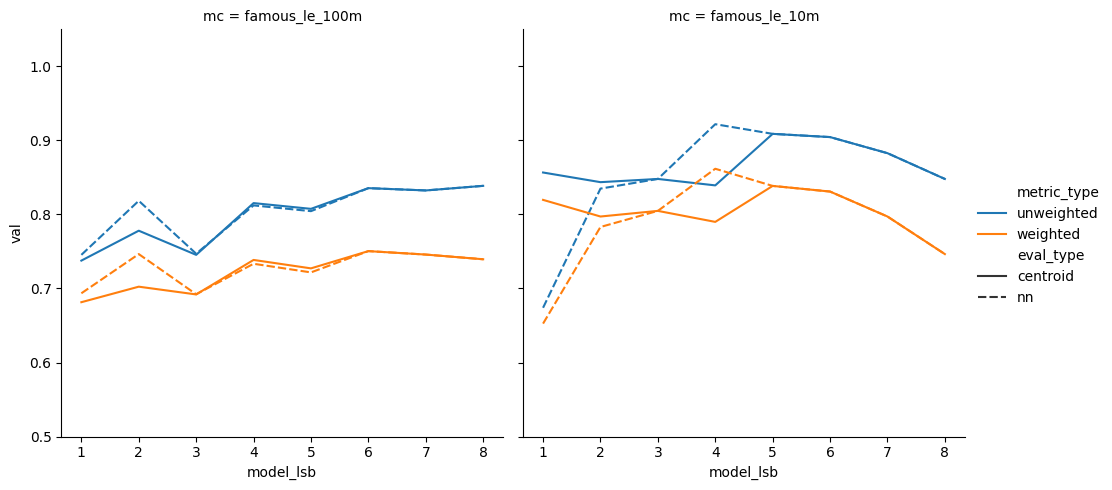

In [7]:
import seaborn as sns

g = sns.relplot(
    data=result_df,
    x='model_lsb',
    y='val',
    col='mc',
    hue='metric_type',
    style='eval_type',
    kind='line'
)

g.set(ylim=(0.5, 1.05))
lsbs = result_df['model_lsb'].unique()
g.set(xticks=lsbs)

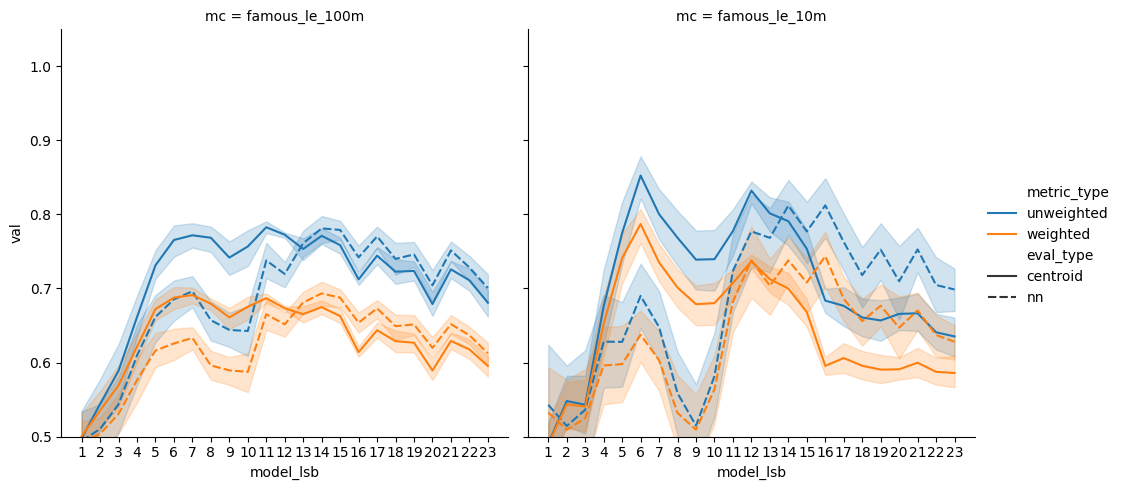

In [132]:
import seaborn as sns

g = sns.relplot(
    data=result_df,
    x='model_lsb',
    y='val',
    col='mc',
    hue='metric_type',
    style='eval_type',
    kind='line'
)

g.set(ylim=(0.5, 1.05))
lsbs = result_df['model_lsb'].unique()
g.set(xticks=lsbs)